<a href="https://colab.research.google.com/github/Iankumu/Drowsiness-Detection/blob/main/Drowsiness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Libraries

In [ ]:
import numpy as np 
import pandas as pd 
import os
import cv2
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
def yawn_faces(direc="/content/drive/MyDrive/Machine Learning/data/train", face_cas_path="/content/drive/MyDrive/Machine Learning/Prediction Images/haarcascade_frontalface_default.xml"):
    yawn = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yawn.append([resized_array, class_num1])
    return yawn


yawn_no_yawn = yawn_faces()

0
1


In [ ]:
def get_data(dir_path="/content/drive/MyDrive/Machine Learning/data/train", face_cas="/content/drive/MyDrive/Machine Learning/Prediction Images/haarcascade_frontalface_default.xml", eye_cas="/content/drive/MyDrive/Machine Learning/Prediction Images/haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [ ]:
data_train = get_data()

2
3


In [ ]:
def append_data():
#     total_data = []
    yawn = yawn_faces()
    data = get_data()
    yawn.extend(data)
    return np.array(yawn)

In [ ]:
new_data = append_data()

0
1
2
3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


##Separate Labels and Features

In [ ]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

##Reshape the Array

In [ ]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

##Convert Multiclass Labels to Binary Labels 

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [ ]:
y = np.array(y)

In [ ]:
X.shape

(1644, 145, 145, 3)

##Split the data into Train Set and Test Set

In [ ]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [ ]:
X_train.shape

(1150, 145, 145, 3)

In [ ]:
len(X_train)

1150

##Randomize the training images for better performance

In [ ]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

##Train the Model

In [ ]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [ ]:
history = model.fit(train_generator, epochs=15, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/15
36/36 [==============================] - 25s 260ms/step - loss: 0.9901 - accuracy: 0.5530 - val_loss: 0.7214 - val_accuracy: 0.6822
Epoch 2/15
36/36 [==============================] - 7s 188ms/step - loss: 0.5248 - accuracy: 0.7809 - val_loss: 0.3359 - val_accuracy: 0.8664
Epoch 3/15
36/36 [==============================] - 7s 190ms/step - loss: 0.4161 - accuracy: 0.8174 - val_loss: 0.2847 - val_accuracy: 0.8947
Epoch 4/15
36/36 [==============================] - 7s 192ms/step - loss: 0.3380 - accuracy: 0.8574 - val_loss: 0.2898 - val_accuracy: 0.8765
Epoch 5/15
36/36 [==============================] - 7s 194ms/step - loss: 0.3166 - accuracy: 0.8713 - val_loss: 0.3175 - val_accuracy: 0.8704
Epoch 6/15
36/36 [==============================] - 7s 192ms/step - loss: 0.2692 - accuracy: 0.8930 - val_loss: 0.2163 - val_accuracy: 0.9231
Epoch 7/15
36/36 [==============================] - 7s 192ms/step - loss: 0.2636 - accuracy: 0.8870 - val_loss: 0.2117 - val_accuracy: 0.9130
Epoch

##Performance of the Model

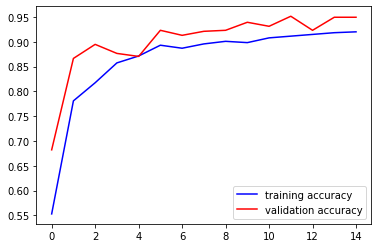

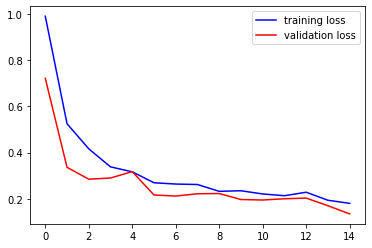

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="training accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="training loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

##Save the Model

In [ ]:
model.save("drowsiness_new.h5",overwrite=True)

In [ ]:
prediction=np.argmax(model.predict(X_test), axis=1)
prediction

array([2, 3, 3, 2, 2, 3, 2, 2, 3, 1, 2, 3, 3, 3, 2, 2, 2, 2, 3, 2, 3, 3,
       3, 2, 3, 3, 3, 2, 3, 1, 3, 0, 2, 1, 2, 3, 3, 2, 0, 2, 1, 2, 2, 1,
       1, 3, 2, 2, 1, 1, 1, 2, 2, 3, 3, 2, 1, 2, 0, 2, 3, 0, 2, 0, 1, 0,
       3, 2, 2, 3, 3, 3, 2, 2, 1, 2, 2, 2, 0, 2, 0, 2, 2, 3, 1, 3, 3, 2,
       3, 0, 3, 3, 2, 1, 0, 1, 2, 2, 3, 3, 2, 2, 2, 3, 3, 3, 2, 0, 2, 3,
       1, 2, 1, 2, 3, 1, 3, 3, 3, 3, 2, 1, 0, 3, 2, 2, 2, 3, 3, 1, 3, 2,
       2, 2, 1, 2, 2, 2, 2, 3, 3, 1, 1, 2, 2, 2, 3, 3, 1, 3, 0, 0, 2, 1,
       0, 1, 3, 3, 0, 3, 1, 2, 2, 3, 3, 1, 3, 2, 3, 2, 1, 2, 3, 0, 1, 2,
       2, 2, 3, 3, 2, 3, 3, 2, 2, 3, 0, 3, 2, 2, 2, 3, 2, 3, 2, 3, 3, 1,
       1, 2, 3, 2, 2, 1, 3, 3, 2, 3, 2, 2, 3, 1, 3, 2, 2, 0, 2, 3, 1, 3,
       3, 3, 0, 2, 2, 2, 2, 3, 1, 2, 3, 3, 1, 3, 0, 1, 2, 3, 1, 2, 2, 3,
       0, 3, 2, 3, 1, 1, 1, 3, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2,
       0, 2, 3, 3, 3, 2, 2, 3, 3, 1, 2, 1, 0, 1, 3, 0, 2, 0, 3, 2, 2, 2,
       1, 3, 2, 2, 1, 3, 2, 2, 2, 2, 3, 2, 2, 3, 2,

In [ ]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), prediction, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.87      0.62      0.73        53
     no_yawn       0.75      0.89      0.81        66
      Closed       0.89      0.96      0.92       181
        Open       0.97      0.92      0.94       194

    accuracy                           0.90       494
   macro avg       0.87      0.85      0.85       494
weighted avg       0.90      0.90      0.90       494



In [ ]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="/content/drive/MyDrive/Machine Learning/Prediction Images/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("./drowsiness_new.h5")

In [ ]:
# 0-yawn, 1-no_yawn, 2-Closed, 3-Open

##Test the Model

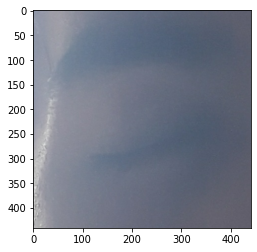

In [ ]:
plt.imshow(plt.imread("/content/drive/MyDrive/Machine Learning/data/test/Closed/_383.jpg"))
plt.show()

In [ ]:
prediction = model.predict([prepare("/content/drive/MyDrive/Machine Learning/data/test/Closed/_383.jpg")])
np.argmax(prediction)

2